In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/symptom2disease/Symptom2Disease.csv


In [4]:
data=pd.read_csv('/kaggle/input/symptom2disease/Symptom2Disease.csv')

In [5]:

import pandas as pd
from sklearn.preprocessing import LabelEncoder



# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Category' column
data['Category_numerical'] = label_encoder.fit_transform(data['label'])

data

Unnamed: 0      label  \
0              0  Psoriasis   
1              1  Psoriasis   
2              2  Psoriasis   
3              3  Psoriasis   
4              4  Psoriasis   
...          ...        ...   
1195         295   diabetes   
1196         296   diabetes   
1197         297   diabetes   
1198         298   diabetes   
1199         299   diabetes   

                                                   text  Category_numerical  
0     I have been experiencing a skin rash on my arm...                  15  
1     My skin has been peeling, especially on my kne...                  15  
2     I have been experiencing joint pain in my fing...                  15  
3     There is a silver like dusting on my skin, esp...                  15  
4     My nails have small dents or pits in them, and...                  15  
...                                                 ...                 ...  
1195  I'm shaking and trembling all over. I've lost ...                  19  
1196  Particularly in the crevices of my skin, I hav...                  19  
1197  I regularly experience these intense urges and...                  19  
1198  I have trouble breathing, especially outside. ...                  19  
1199  I constantly sneeze and have a dry cough. My i...                  19  

[1200 rows x 4 columns]

In [6]:
# List of medical conditions
conditions = [
    'Psoriasis', 'Varicose Veins', 'Typhoid', 'Chicken pox', 'Impetigo', 
    'Dengue', 'Fungal infection', 'Common Cold', 'Pneumonia', 'Dimorphic Hemorrhoids',
    'Arthritis', 'Acne', 'Bronchial Asthma', 'Hypertension', 'Migraine', 
    'Cervical spondylosis', 'Jaundice', 'Malaria', 'urinary tract infection',
    'allergy', 'gastroesophageal reflux disease', 'drug reaction', 
    'peptic ulcer disease', 'diabetes'
]

# Create dictionary with labels starting from 0
condition_dict = {condition: idx for idx, condition in enumerate(conditions)}

# Print the result
print(condition_dict)


{'Psoriasis': 0, 'Varicose Veins': 1, 'Typhoid': 2, 'Chicken pox': 3, 'Impetigo': 4, 'Dengue': 5, 'Fungal infection': 6, 'Common Cold': 7, 'Pneumonia': 8, 'Dimorphic Hemorrhoids': 9, 'Arthritis': 10, 'Acne': 11, 'Bronchial Asthma': 12, 'Hypertension': 13, 'Migraine': 14, 'Cervical spondylosis': 15, 'Jaundice': 16, 'Malaria': 17, 'urinary tract infection': 18, 'allergy': 19, 'gastroesophageal reflux disease': 20, 'drug reaction': 21, 'peptic ulcer disease': 22, 'diabetes': 23}


In [7]:
data['label']=data['label'].map(condition_dict)

In [8]:
data

Unnamed: 0  label                                               text  \
0              0      0  I have been experiencing a skin rash on my arm...   
1              1      0  My skin has been peeling, especially on my kne...   
2              2      0  I have been experiencing joint pain in my fing...   
3              3      0  There is a silver like dusting on my skin, esp...   
4              4      0  My nails have small dents or pits in them, and...   
...          ...    ...                                                ...   
1195         295     23  I'm shaking and trembling all over. I've lost ...   
1196         296     23  Particularly in the crevices of my skin, I hav...   
1197         297     23  I regularly experience these intense urges and...   
1198         298     23  I have trouble breathing, especially outside. ...   
1199         299     23  I constantly sneeze and have a dry cough. My i...   

      Category_numerical  
0                     15  
1                     15  
2                     15  
3                     15  
4                     15  
...                  ...  
1195                  19  
1196                  19  
1197                  19  
1198                  19  
1199                  19  

[1200 rows x 4 columns]

In [58]:
from transformers import BertModel, BertTokenizer, GPT2Tokenizer, AdamW,GPT2Model,TrainingArguments,Trainer
import torch
from torch import nn
from transformers import BertModel, BertTokenizer, GPT2Tokenizer, AdamW
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset as HFDataset, DatasetDict
class BERTGPTClassifier(nn.Module):
    def __init__(self, bert_model_name="cambridgeltl/SapBERT-from-PubMedBERT-fulltext", gpt_model_name="gpt2", num_labels=24):
        super(BERTGPTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.gpt = GPT2Model.from_pretrained(gpt_model_name)

        # Define the classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size + self.gpt.config.n_embd, 128),
            nn.ReLU(),
            nn.Dropout(0.3),  # Regularization with dropout to prevent overfitting
            nn.Linear(128, num_labels)
        )
    
    def forward(self, input_ids, attention_mask, gpt_input_ids=None, labels=None):
        # Get BERT embeddings
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_cls_output = bert_outputs.pooler_output  # Use [CLS] token embeddings
        
        # Get GPT embeddings
        gpt_outputs = self.gpt(input_ids=gpt_input_ids)
        gpt_cls_output = gpt_outputs.last_hidden_state[:, -1, :]  # Use the last token embedding
        
        # Concatenate BERT and GPT embeddings
        combined_embeddings = torch.cat((bert_cls_output, gpt_cls_output), dim=1)

        # Classification
        logits = self.classifier(combined_embeddings)
        
        # If labels are provided, compute loss
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        
        return {'loss': loss, 'logits': logits} if loss is not None else logits


In [59]:


# Load BERT and GPT tokenizers
bert_tokenizer = BertTokenizer.from_pretrained("cambridgeltl/SapBERT-from-PubMedBERT-fulltext")
gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token  # GPT-2 doesn't have a pad token, so we set it to EOS

# Assuming `balanced_df` is your DataFrame
train_df, eval_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

# Convert the pandas DataFrames to Hugging Face Datasets
train_dataset = HFDataset.from_pandas(train_df)
eval_dataset = HFDataset.from_pandas(eval_df)

# Create a DatasetDict to hold the training and evaluation datasets
dataset_dict = DatasetDict({
    'train': train_dataset,
    'eval': eval_dataset
})

# Preprocess the dataset
def preprocess_function(examples):
    bert_encodings = bert_tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)
    gpt_encodings = gpt_tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)
    
    return {
        'input_ids': bert_encodings['input_ids'],
        'attention_mask': bert_encodings['attention_mask'],
        'gpt_input_ids': gpt_encodings['input_ids'],
        'labels': examples['label']
    }

tokenized_datasets = dataset_dict.map(preprocess_function, batched=True)

# Prepare the dataset for PyTorch
tokenized_datasets.set_format("torch", columns=['input_ids', 'attention_mask', 'gpt_input_ids', 'labels'])


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

In [60]:
# Initialize the model
model = BERTGPTClassifier()

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    evaluation_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=1,
    report_to=[]  # Disable reporting to wandb

)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['eval'],
)

# Train the model
trainer.train()




/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=300, training_loss=1.963103837966919, metrics={'train_runtime': 568.138, 'train_samples_per_second': 33.795, 'train_steps_per_second': 0.528, 'total_flos': 0.0, 'train_loss': 1.963103837966919, 'epoch': 20.0})

Class 0:
  Precision: 1.00
  Recall:    0.80
  F1 Score:  0.89
Class 1:
  Precision: 1.00
  Recall:    1.00
  F1 Score:  1.00
Class 2:
  Precision: 1.00
  Recall:    0.90
  F1 Score:  0.95
Class 3:
  Precision: 0.71
  Recall:    1.00
  F1 Score:  0.83
Class 4:
  Precision: 1.00
  Recall:    0.80
  F1 Score:  0.89
Class 5:
  Precision: 0.89
  Recall:    0.80
  F1 Score:  0.84
Class 6:
  Precision: 1.00
  Recall:    1.00
  F1 Score:  1.00
Class 7:
  Precision: 0.83
  Recall:    1.00
  F1 Score:  0.91
Class 8:
  Precision: 1.00
  Recall:    1.00
  F1 Score:  1.00
Class 9:
  Precision: 0.83
  Recall:    1.00
  F1 Score:  0.91
Class 10:
  Precision: 1.00
  Recall:    1.00
  F1 Score:  1.00
Class 11:
  Precision: 1.00
  Recall:    0.90
  F1 Score:  0.95
Class 12:
  Precision: 1.00
  Recall:    1.00
  F1 Score:  1.00
Class 13:
  Precision: 0.91
  Recall:    1.00
  F1 Score:  0.95
Class 14:
  Precision: 1.00
  Recall:    1.00
  F1 Score:  1.00
Class 15:
  Precision: 1.00
  Recall:    1.00
  F1

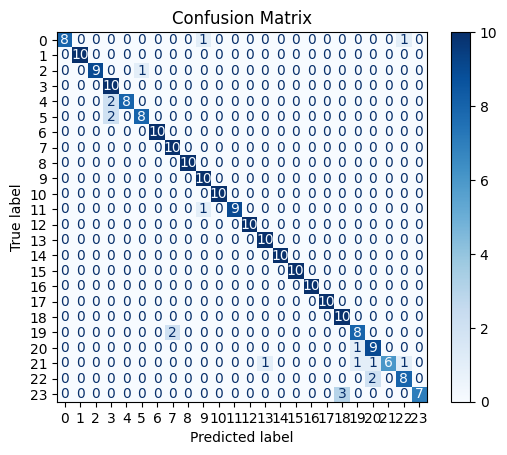

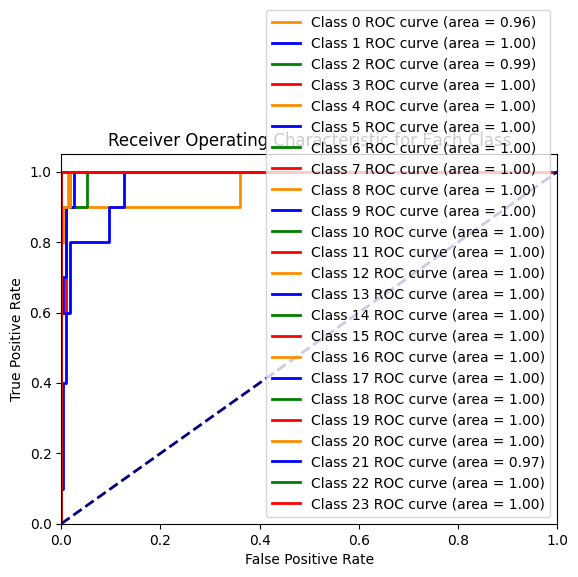

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Generate predictions and true labels
predictions = trainer.predict(tokenized_datasets['eval'])
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids



# Calculate precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average=None)

# Get the unique labels
labels = np.unique(true_labels)

# Print the precision, recall, and F1 score for each class
for i, label in enumerate(labels):
    print(f"Class {label}:")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall:    {recall[i]:.2f}")
    print(f"  F1 Score:  {f1[i]:.2f}")

# Optionally, you can calculate the average scores
avg_precision, avg_recall, avg_f1, _ = precision_recall_fscore_support(true_labels, preds, average='weighted')

print(f"\nAverage Precision: {avg_precision:.2f}")
print(f"Average Recall:    {avg_recall:.2f}")
print(f"Average F1 Score:  {avg_f1:.2f}")

# Compute accuracy
accuracy = accuracy_score(true_labels, preds)
print(f'Accuracy: {accuracy:.2f}')

# Print the number of samples for each class and total samples
unique, counts = np.unique(true_labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
total_samples = len(true_labels)
print(f'Class Distribution: {class_distribution}')
print(f'Total Samples: {total_samples}')

# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[ i for i in range(0,24)])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 24

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predictions.predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['darkorange', 'blue', 'green', 'red']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2, label=f'Class {i} ROC curve (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()


## Explanation

In [62]:
import numpy as np
from lime.lime_text import LimeTextExplainer

# Assuming your custom model is already initialized
model = trainer.model.to('cuda')  # Make sure your model is on the same device

def predict_proba(texts):
    probabilities = []
    
    for text in texts:
        # Tokenize the input text using both BERT and GPT tokenizers
        bert_encoding = bert_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
        gpt_encoding = gpt_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)

        # Move the inputs to the GPU (or CPU, depending on availability)
        bert_input_ids = bert_encoding['input_ids'].to('cuda')
        bert_attention_mask = bert_encoding['attention_mask'].to('cuda')
        gpt_input_ids = gpt_encoding['input_ids'].to('cuda')
        
        # Set the model to evaluation mode and disable gradient computation
        model.eval()
        with torch.no_grad():
            # Get the logits from the model
            output = model(input_ids=bert_input_ids, attention_mask=bert_attention_mask, gpt_input_ids=gpt_input_ids)
            
            # If the output is a dictionary, retrieve logits
            if isinstance(output, dict):
                logits = output['logits']
            else:
                logits = output
            
            # Convert logits to probabilities using softmax
            probs = torch.nn.functional.softmax(logits, dim=1).squeeze().cpu().numpy()
            probabilities.append(probs)
    
    return np.array(probabilities)


# Initialize the LIME text explainer
explainer = LimeTextExplainer(class_names=[f'Class {i}' for i in range(24)])




In [63]:

reversed_map = {value: key for key, value in condition_dict.items()}

j=0
for index,row in eval_df.iterrows():
    if j>5:
        break
    exp = explainer.explain_instance(row['text'], predict_proba, num_features=10,labels=[row['label']])

    # Visualize the explanation
    exp.show_in_notebook(text=True)
    print(f" True Label is :{row['label']} {reversed_map[row['label']]}")

    j+=1
   
    
    
# # Explain the prediction for the given text
# exp = explainer.explain_instance(text, predict_proba, num_features=15)

# # Visualize the explanation in the notebook
# exp.show_in_notebook(text=True)


 True Label is :14 Migraine


 True Label is :12 Bronchial Asthma


 True Label is :6 Fungal infection


 True Label is :7 Common Cold


 True Label is :1 Varicose Veins


 True Label is :11 Acne


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict  # Correct import from datasets library

# Assuming `data` is a pandas DataFrame with a 'text' column and 'label' column
# Split the original dataset into training and evaluation sets.
train_df, eval_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

# Convert the pandas DataFrames to Hugging Face Datasets.
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

# Create a DatasetDict to hold the training and evaluation datasets.
dataset_dict = DatasetDict({
    'train': train_dataset,
    'eval': eval_dataset
})

# Specify the checkpoint of the pre-trained model to use for tokenization.
model_checkpoint = "cambridgeltl/SapBERT-from-PubMedBERT-fulltext"

# Load the tokenizer from the specified checkpoint.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Define a function to tokenize the input examples.
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

# Apply the tokenization function to the datasets.
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True, remove_columns=["text"])

# Now the tokenized_datasets are ready to be used for model training


In [ ]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer, BertConfig, DataCollatorWithPadding

# Load the configuration for BERT model from a pretrained model directory.
# Adjust the dropout probabilities and specify the number of output labels.
model_config = BertConfig.from_pretrained(model_checkpoint, hidden_dropout_prob=0.25, 
                                          attention_probs_dropout_prob=0.15, num_labels=24)

# Load the BERT model for sequence classification from a pretrained model directory.
# The model is trained on a specific dataset relevant to the task.
model = BertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=24)

# Create a data collator that dynamically pads the inputs to the longest sequence in a batch.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define the training arguments for the Trainer.
# Specifies the output directory, evaluation strategy, learning rate, batch sizes, number of epochs, etc.
training_args = TrainingArguments(
    output_dir="./results",              # Directory to save the model checkpoints and training results.
    evaluation_strategy="epoch",         # Evaluate the model at the end of each epoch.
    learning_rate=2e-5,                  # Learning rate for the optimizer.
    per_device_train_batch_size=16,      # Batch size for training.
    per_device_eval_batch_size=16,       # Batch size for evaluation.
    num_train_epochs=6,                  # Number of epochs to train the model.
    save_total_limit=1,                  # Limit the total amount of checkpoints to save.
    weight_decay=0.01,
    report_to=[]
)

# Initialize the Trainer with the model, training arguments, datasets, tokenizer, and data collator.
trainer = Trainer(
    model=model,                          # The model to train.
    args=training_args,                   # Training arguments.
    train_dataset=tokenized_datasets['train'],  # Training dataset.
    eval_dataset=tokenized_datasets['eval'],    # Evaluation dataset.
    tokenizer=tokenizer,                  # Tokenizer used for preprocessing.
    data_collator=data_collator           # Data collator for dynamic padding.
)

# Start the training process.
trainer.train()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Generate predictions and true labels
predictions = trainer.predict(tokenized_datasets['eval'])
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids



# Calculate precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average=None)

# Get the unique labels
labels = np.unique(true_labels)

# Print the precision, recall, and F1 score for each class
for i, label in enumerate(labels):
    print(f"Class {label}:")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall:    {recall[i]:.2f}")
    print(f"  F1 Score:  {f1[i]:.2f}")

# Optionally, you can calculate the average scores
avg_precision, avg_recall, avg_f1, _ = precision_recall_fscore_support(true_labels, preds, average='weighted')

print(f"\nAverage Precision: {avg_precision:.2f}")
print(f"Average Recall:    {avg_recall:.2f}")
print(f"Average F1 Score:  {avg_f1:.2f}")

# Compute accuracy
accuracy = accuracy_score(true_labels, preds)
print(f'Accuracy: {accuracy:.2f}')

# Print the number of samples for each class and total samples
unique, counts = np.unique(true_labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
total_samples = len(true_labels)
print(f'Class Distribution: {class_distribution}')
print(f'Total Samples: {total_samples}')

# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[ i for i in range(0,24)])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 24

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predictions.predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['darkorange', 'blue', 'green', 'red']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2, label=f'Class {i} ROC curve (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import numpy as np
import torch
from transformers import BertTokenizer
from lime.lime_text import LimeTextExplainer

# Load your BERT model and tokenizer
model = trainer.model.to('cuda')
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

# Define a prediction function for LIME without batching
def predict_proba(texts):
    probabilities = []
    
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {key: value.to('cuda') for key, value in inputs.items()}
        
        with torch.no_grad():  # Disable gradient calculation to save memory
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1).squeeze().cpu().numpy()
        
        probabilities.append(probs)
    
    return np.array(probabilities)


class_names = [f'Class {i}' for i in range(24)]  # Replace with actual class names if available
explainer = LimeTextExplainer(class_names=class_names)

In [ ]:
import numpy as np
import torch
from transformers import BertTokenizer
from lime.lime_text import LimeTextExplainer

# Load your BERT model and tokenizer
model = trainer.model.to('cuda')
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

# Define a prediction function for LIME without batching
def predict_proba(texts):
    probabilities = []
    
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {key: value.to('cuda') for key, value in inputs.items()}
        
        with torch.no_grad():  # Disable gradient calculation to save memory
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1).squeeze().cpu().numpy()
        
        probabilities.append(probs)
    
    return np.array(probabilities)


class_names = [f'Class {i}' for i in range(24)]  # Replace with actual class names if available
explainer = LimeTextExplainer(class_names=class_names)


In [ ]:
eval_df

In [ ]:
reversed_map = {value: key for key, value in condition_dict.items()}


In [ ]:
# j=0
# for index,row in eval_df.iterrows():
#     if j>5:
#         break
#     exp = explainer.explain_instance(row['text'], predict_proba, num_features=15,labels=[row['label']])

#     # Visualize the explanation
#     exp.show_in_notebook(text=True)
#     print(f" True Label is :{row['label']} {reversed_map[row['label']]}")

#     j+=1
   
    
    
    

In [ ]:
j = 0
html_content = "<html><head><title>LIME Explanations</title></head><body>"

for index, row in eval_df.iterrows():
    if j > 5:
        break

    # Generate the LIME explanation for the specific text and label
    exp = explainer.explain_instance(row['text'], predict_proba, num_features=15, labels=[row['label']])
    
    # Save the explanation as HTML content
    explanation_html = exp.as_html()
    html_content += f"<h2>Explanation for Instance {j}</h2>"
    html_content += f"<p>True Label: {row['label']} - {reversed_map[row['label']]}</p>"
    html_content += explanation_html
    html_content += "<hr>"  # Separator between explanations
    
    j += 1

# Close the HTML body and write to a file
html_content += "</body></html>"

# Save to a single HTML file
with open("lime_explanations.html", "w") as file:
    file.write(html_content)

print("Explanations saved to lime_explanations.html")


In [ ]:
device='cuda'
# Explain the prediction
exp = explainer.explain_instance(text, predict_proba, num_features=15)

# Visualize the explanation
exp.show_in_notebook(text=True)
explanation_list = exp.as_list()

# Print the explanation as a list
for word, contribution in explanation_list:
    print(f"Word: {word}, Contribution: {contribution:.4f}")
